# Timetree Analysis

1. Plot root-to-tip regression with date (tips).
1. Estimate a time-scaled phylogeny.
1. Plot root-to-tip regression with date (tips+internals)
1. Plot timetree.

**Table of Contents**

1. Setup
1. Clock Analysis
1. Post-Process
1. Plot


**TO-DO**:

1. Plot subtrees
    - Second pandemic
    - First pandemic
1. Refine timetree parameters, specifically:
    - Relaxed clock
    - Marginal date estimation and confidence
1. Visualize rates on timetree

---
## 1. Setup

### Import Modules

In [61]:
import treetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches, lines, gridspec, colors
from Bio import Phylo, AlignIO
import os
import io
import sys
import numpy as np
import pandas as pd
import random
import math
import copy
import scipy
import augur
import plotly

### Variables

In [181]:
# Paths
tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
metadata_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"
outdir = "../../docs/results/latest/timetree/"

# Pandas
#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", None)
#pd.set_option("display.max_rows", 10, "display.max_columns", 10)

# General
NO_DATA_CHAR = "NA"
DATE_COL = "Date"
TERM_COL = "grey"
NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()

# IO
BRANCH_LEN_SIG_DIG = 12

# Clock models
REF_DATE = 1992.0
REF_LEN = 4653728
CONFIDENCE=0.95
N_IQD=3
TIME_MARGINAL = False
SEQ_MARGINAL  = False
MAX_ITER = 3
RELAXED_CLOCK = {"slack":1.0, "coupling": 0}
# RELAXED_CLOCK = False 
    
# Matplotlib
FMT = "svg"

SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

figsize=(6.4, 4.8)
figsize_alt=(9.6,4.8)
figsize_alt2=(4,4)

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
plt.rc('legend', title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc('legend', frameon=False)  # legend frame
plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels
plt.rc('axes', titlesize=LG_FONT) # fontsize of axis titles
plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
dpi = 400

# Discrete Color Palette
DISC_COLOR_PAL = "tab10"
DISC_CMAP_N = 10
DISC_CMAP = plt.get_cmap(DISC_COLOR_PAL, DISC_CMAP_N)
DISC_CMAPLIST = [DISC_CMAP(i) for i in range(DISC_CMAP.N)]

CONT_COLOR_PAL = "rainbow"

# Mugration
MUG_ATTR = "Branch_Major"
MUG_CONF_THRESH = 0.95

## Functions

In [105]:
# This code is from the biopython Phylo module

def get_x_positions(tree):
    """
    Create a mapping of each clade to its horizontal position.
    Dict of {clade: x-coord}
    """
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if not max(depths.values()):
        depths = tree.depths(unit_branch_lengths=True)
    return depths

def get_y_positions(tree):
    """
    Create a mapping of each clade to its vertical position.
    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

# My own conversion function
def convert_timetree_ticks(tree, step):
    """
    Return a dict of axis locations and labels for an input timetree tree.
    """
    # Step 1: Figure out offset to convert year branch length to calendar date
    min_date = tree.root.numdate - tree.root.branch_length
    max_date = np.max([n.numdate for n in tree.get_terminals()])
    offset = min_date
    date_range = np.max([n.numdate for n in tree.get_terminals()]) - min_date

    # Step 2: Relabel xticks and space them differently
    # Distance between ticks
    dtick = step
    # Minimum tick value
    min_tick = step*(offset//step)

    # Extra tick increment
    extra = dtick if dtick<date_range else dtick
    # New tick values
    tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
    # New tick locations
    tick_locs = tick_vals - offset
    # New tick labels
    tick_labels = ["%d"%(int(x)) for x in tick_vals]
    return {"tick_locs": tick_locs, "tick_labels": tick_labels}

def color_tree(tree, df, attribute, attribute_confidence, threshold_confidence, color_pal="rainbow"):
    """
    Color branches of a tree using a data frame and addtribute.
    Returns a color dictionary and modifies the tree in place.
    """
    # Create the custom color map
    COLOR_PAL="rainbow"
    attr_states = list(dict.fromkeys(df[attribute]))

    # Create the custom color map (pyplot)
    cmap = plt.get_cmap(color_pal, len(attr_states))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]

    hex_dict = {}

    # Assign states colors based on tip order (Low Conf first as grey)
    for state,hex_col in zip(attr_states, attr_hex):
        hex_dict[state] = hex_col
        
    # Change colors on tree
    for c in tree.find_clades(): 
        clade_state = df[attribute][c.name]
        clade_color = hex_dict[clade_state]
        # OPTIONAL: Color grey if low confidence
        if df[attribute_confidence][c.name] < threshold_confidence:
            clade_color = "grey"          
        # Modify tree
        c.color = clade_color
        # Save to dictionary
        
    return hex_dict

### Add constant sites to the snp alignment
MEMORY PERMMITING!

In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [5]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)   """   

'constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}\n\nwith open(constant_sites_path, "r") as infile:\n    constant_sites_list = infile.read().strip().split(",")\n    constant_sites_dict["A"] = int(constant_sites_list[0])\n    constant_sites_dict["C"] = int(constant_sites_list[1])\n    constant_sites_dict["G"] = int(constant_sites_list[2])\n    constant_sites_dict["T"] = int(constant_sites_list[3])    \n\nprint(constant_sites_dict)\ntotal_constant_sites = sum(constant_sites_dict.values())\nprint("Constant Sites:", total_constant_sites)\n\n# Add the constant sites to each sample\n# Iterate through each samples sequence\nfor rec in align:\n    # Iterate through each nucleotide for constant sites\n    for nucleotide,count in constant_sites_dict.items():\n        rec.seq = rec.seq + (nucleotide * count)   '

---
## 2. Clock Analysis

### Intialize TimeTree Object

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Add the reference date
dates["Reference"] = REF_DATE

# Construct the treetime object
# Remember, including the alignment is crucial!
tt = treetime.TreeTime(dates=dates, 
                       aln=align,                     
                       tree=tree_path, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,                        
                      )

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )

# Check rtt
print(tt.date2dist.__dict__)


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.75	-SequenceData: loaded alignment.
0.75	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.75	-SeqData: making compressed alignment...

2.78	-SequenceData: constructed compressed alignment...
2.98	--ClockTree: Setting precision to level 2

3.02	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
3.18	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481
{'clock_rate': 9.668191437748236e-09, 'intercept': 5.1466761659175907e-05, 'chisq': 2.4482378587650225e-08, 'r_val': 0.4980791900560189, 'cov': None, 'sigma': 0, 'valid_confidence': False}


### Analyze Timetree Object

In [11]:
# Initialize stdout capture
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

# PARAM MIN: root='-4101-09-02'
# tt.run()

# PARAM STABLE='-4030-01-03'
# My suspicion is that the branch length mode is the key variable
"""
tt.run(resolve_polytomies=False, 
       Tc="skyline", 
       max_iter=3,
       relaxed_clock={"slack":1.0, "coupling": 0},
       infer_gtr=True,
       )
"""

# PARAM TEST='-4083-05-20'
# My suspicion is that the branch length mode is the key variable
tt.run(resolve_polytomies=False, 
       Tc="skyline", 
       max_iter=MAX_ITER,
       relaxed_clock={"slack":1.0, "coupling": 0},
       infer_gtr=True,
       time_marginal=TIME_MARGINAL,
       sequence_margial=SEQ_MARGINAL,
       )

# PARAM SET X date='-19904-12-03'
"""
tt.run(branch_length_mode = "input",
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":1.0, "coupling": 0},
               max_iter=3,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
              )
"""

# Save stdout to file
output = new_stdout.getvalue()
out_path = os.path.join(outdir, SCRIPT_NAME + ".log") 
with open(out_path, "w") as file:
    file.write(output)
# Restore stdout
sys.stdout = old_stdout
print("Standard output restored.")

Standard output restored.


In [13]:
# Quick check
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, date='-4083-05-20', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=0.0)

### Import the divergence tree

In [98]:
tree_div = Phylo.read(tree_path, "newick")

---
## 3. Post-Process

### Ladderize trees

In [97]:
# By default, oldest nodes first
tree_div.ladderize(reverse=False)
tt.tree.ladderize(reverse=False)

### Save 'default' stats

Save statistics that don't require much additional manipulation

min_gamma:  ['GCA_000986995.1_YPES001-SEQ-2-ASM-1_genomic', 0.1]
max_gamma:  ['NODE523', 5.339317965542888]
gamma ratio:  53.393179655428874


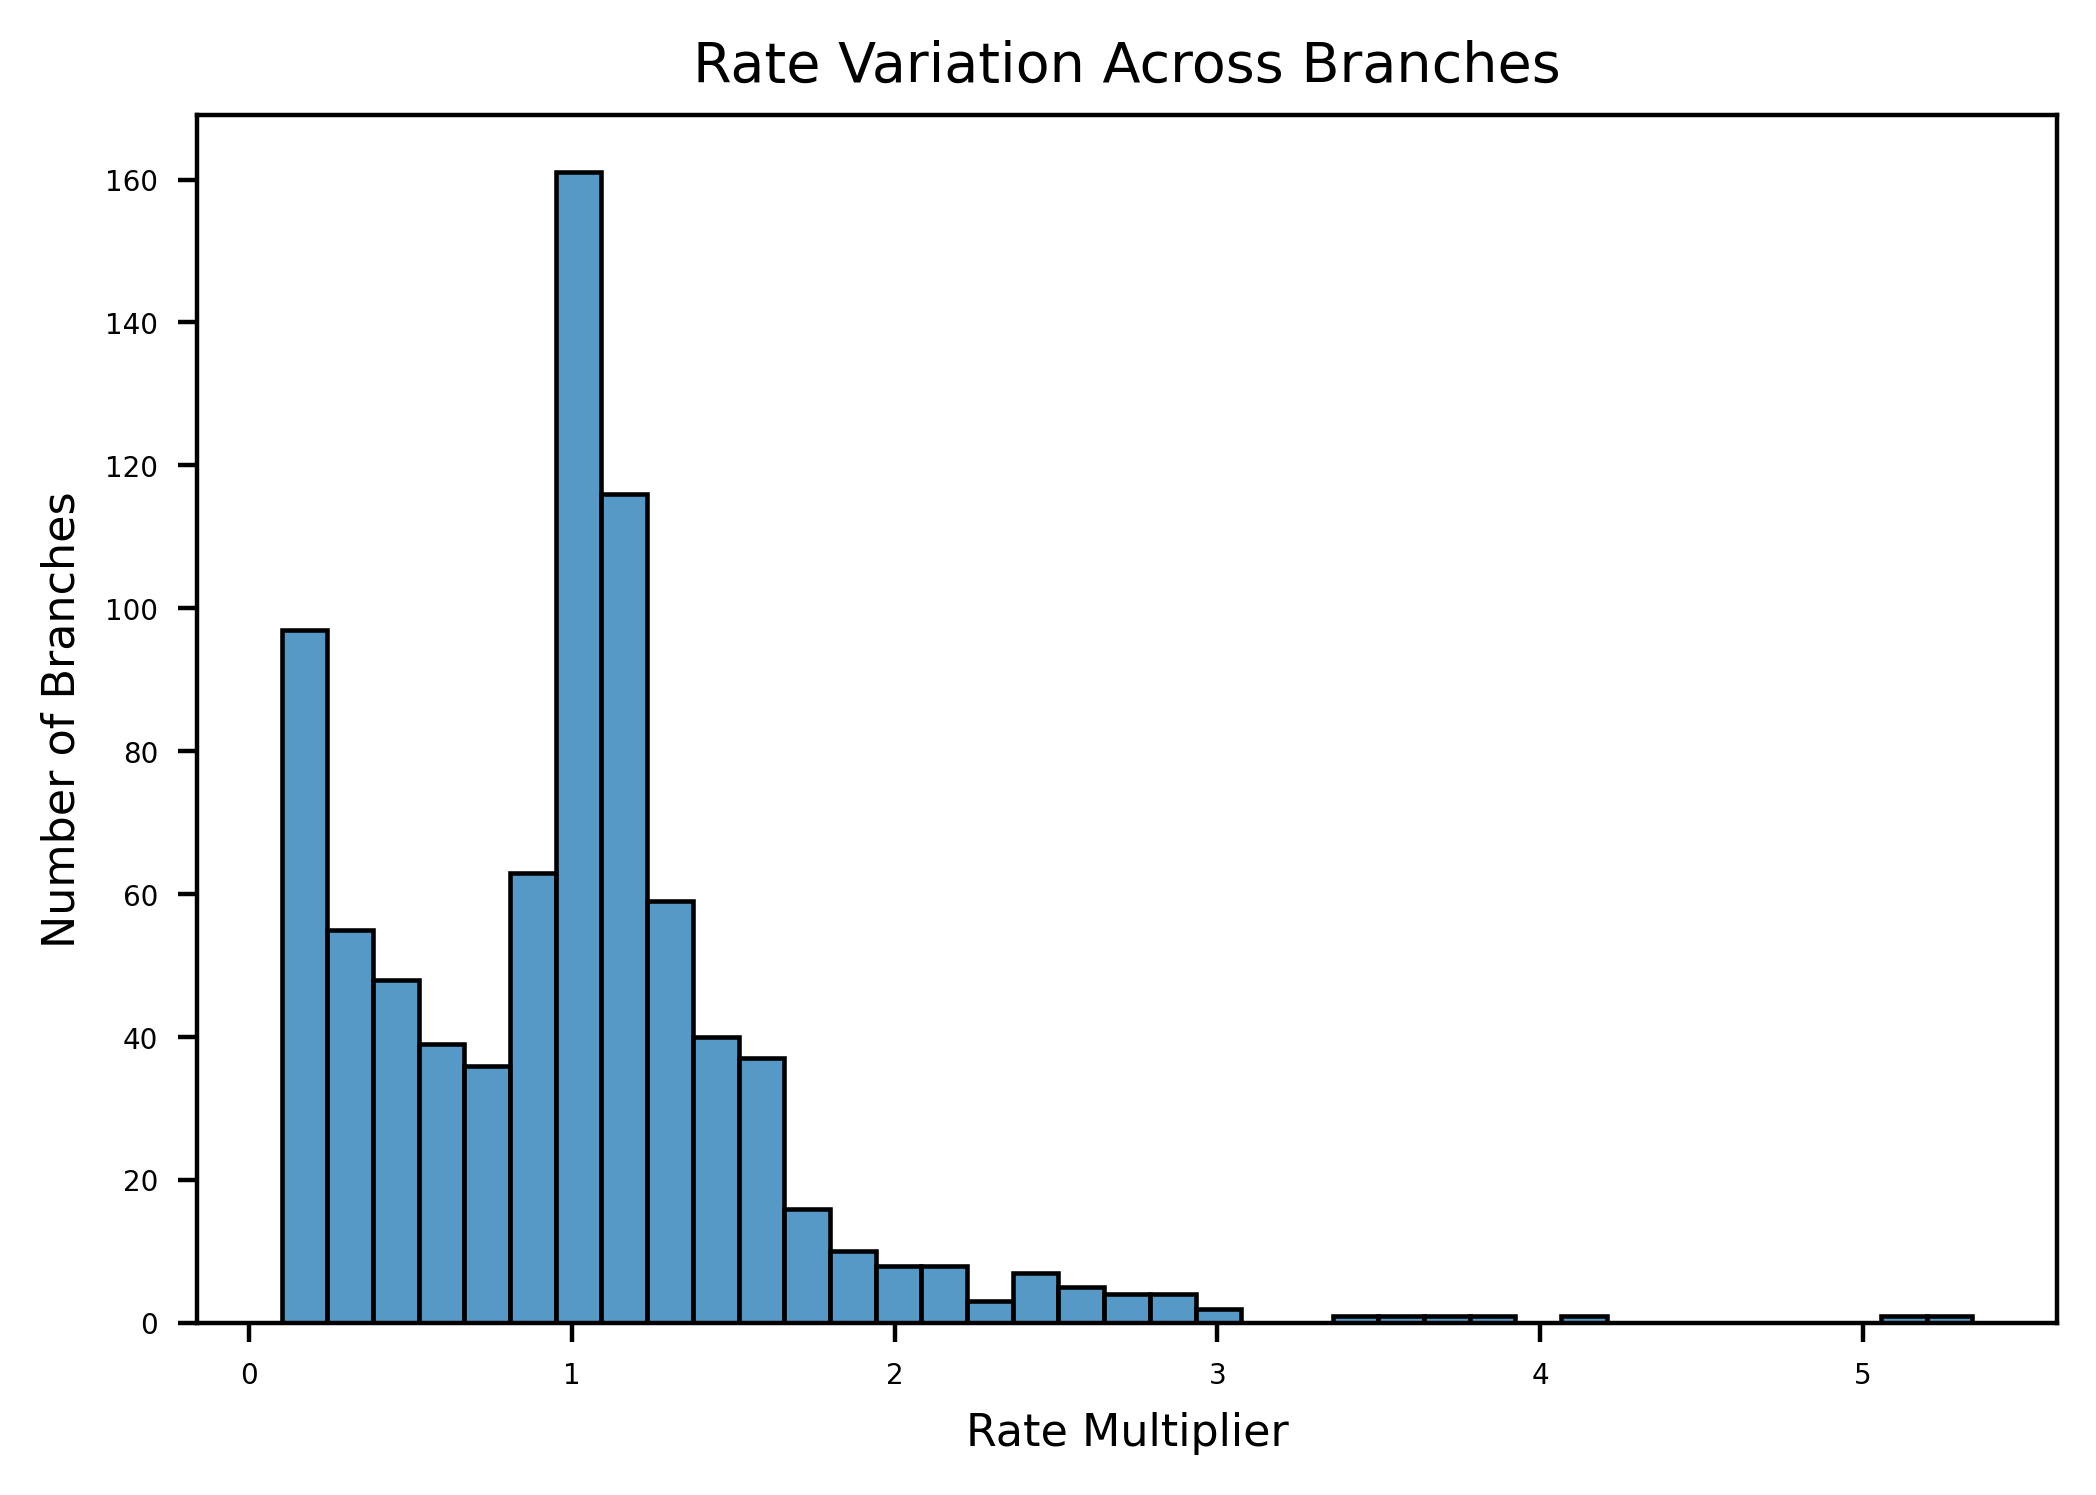

In [17]:
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
with open(out_path_gtr, 'w', encoding='utf-8') as outfile:
    outfile.write(str(tt.gtr)+'\n')

# ----------------------------
# Marginal Confidence
if TIME_MARGINAL:
    out_path_dates = os.path.join(outdir, SCRIPT_NAME + "_dates.tsv")

    with open(out_path_dates, "w") as outfile:
        outfile.write('#Lower and upper bound delineate the {0:.0f}% max posterior region\n'.format(CONFIDENCE*100))
        outfile.write('#node\tdate\tnumeric date\tlower bound\tupper bound\n')

        for c in tt.tree.find_clades():
            if c.bad_branch:
                # Should these be NO DATA CHAR instead?
                outfile.write(c.name + "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + "\n")
                outfile.write('%s\t--\t--\t--\t--\n'%(c.name))
            else:
                conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE) 
                outfile.write('%s\t%s\t%f\t%f\t%f\n'%(c.name, c.date, c.numdate,conf[0], conf[1]))
                
# ----------------------------
# Rate Variation
if RELAXED_CLOCK:
    min_gamma = ['', 1]
    max_gamma = ['', 1]
    gamma_dict = {}

    out_path_rates = os.path.join(outdir, SCRIPT_NAME + "_rates.tsv")
    with open(out_path_rates, "w") as outfile:
        outfile.write("#node\tclock_length\tmutation_length\trate\tfold_change\n")

        for c in tt.tree.find_clades(order="preorder"):
            if c==tt.tree.root:
                continue
            g = c.branch_length_interpolator.gamma
            if g <= min_gamma[1]:
                min_gamma[0] = c.name
                min_gamma[1] = g
            if g >= max_gamma[1]:
                max_gamma[0] = c.name
                max_gamma[1] = g
            outfile.write("%s\t%1.3e\t%1.3e\t%1.3e\t%1.2f\n"%(c.name, c.clock_length, c.mutation_length, tt.date2dist.clock_rate*g, g))
            gamma_dict[c.name] = g

    print("min_gamma: ", min_gamma)
    print("max_gamma: ", max_gamma)
    print("gamma ratio: ", max_gamma[1] / min_gamma[1])     
    
    # PLOT
    fig, ax1 = plt.subplots(1, dpi=dpi)

    sns.histplot(x = list(gamma_dict.values()), 
             ax=ax1,
             alpha=0.75,
             ) 
    
    ax1.set_xlabel("Rate Multiplier")
    ax1.set_ylabel("Number of Branches")
    #ax1.set_xlim(0,max_gamma[1])
    ax1.set_title("Rate Variation Across Branches")
    
    # Save
    out_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Add stats to dataframe

In [18]:
tree_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Create new columns
tree_df["timetree_" + DATE_COL] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Add x and y coordinates
for c in tt_copy.tree.find_clades():       
    # Add dates and confidence
    tree_df.at[c.name, "timetree_" + DATE_COL] = c.numdate
    #conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
    #tree_df.at[c.name, "timetree_" + DATE_COL] = conf
    
    # Scatter coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad
    
tree_df

451.39	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Color,timetree_Date,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0.000000,16.975763,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Bronze Age,0.998711,#8000ff,-4082.62,0.1,17.0822,-4082.62,0,False
SAMEA3541827,NA,NA,3.891500e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827,Bronze Age,1.000000,#8000ff,-2876,1206.72,1,-2776.5,3.43964e-06,False
NODE2,100,81.3,1.370850e-05,red,0.000014,2.968750,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Bronze Age,0.999998,#8000ff,-3053.4,1029.32,2.96875,-3053.4,1.18361e-05,False
SAMEA104233046,NA,NA,2.760700e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA104233046,Bronze Age,1.000000,#8000ff,-2621,1461.72,2,-2546.5,1.42012e-05,False
NODE4,100,100,1.114500e-06,red,0.000015,3.937500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Bronze Age,1.000000,#8000ff,-3007.19,1075.53,3.9375,-3007.19,1.24808e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,0.000076,520.000000,PY-36,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141469,1.ORI,1.000000,#ff0000,2010,6092.72,515,2010,6.79712e-05,False
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,0.000075,521.000000,PY-66,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141487,1.ORI,1.000000,#ff0000,2010,6092.72,516,2010,6.75414e-05,False
NODE1041,100,97.9,1.172000e-06,red,0.000076,522.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.ORI,1.000000,#ff0000,2004.2,6086.92,519.5,2004.2,6.86159e-05,False


---
## Plot

### Root To Tip Regression

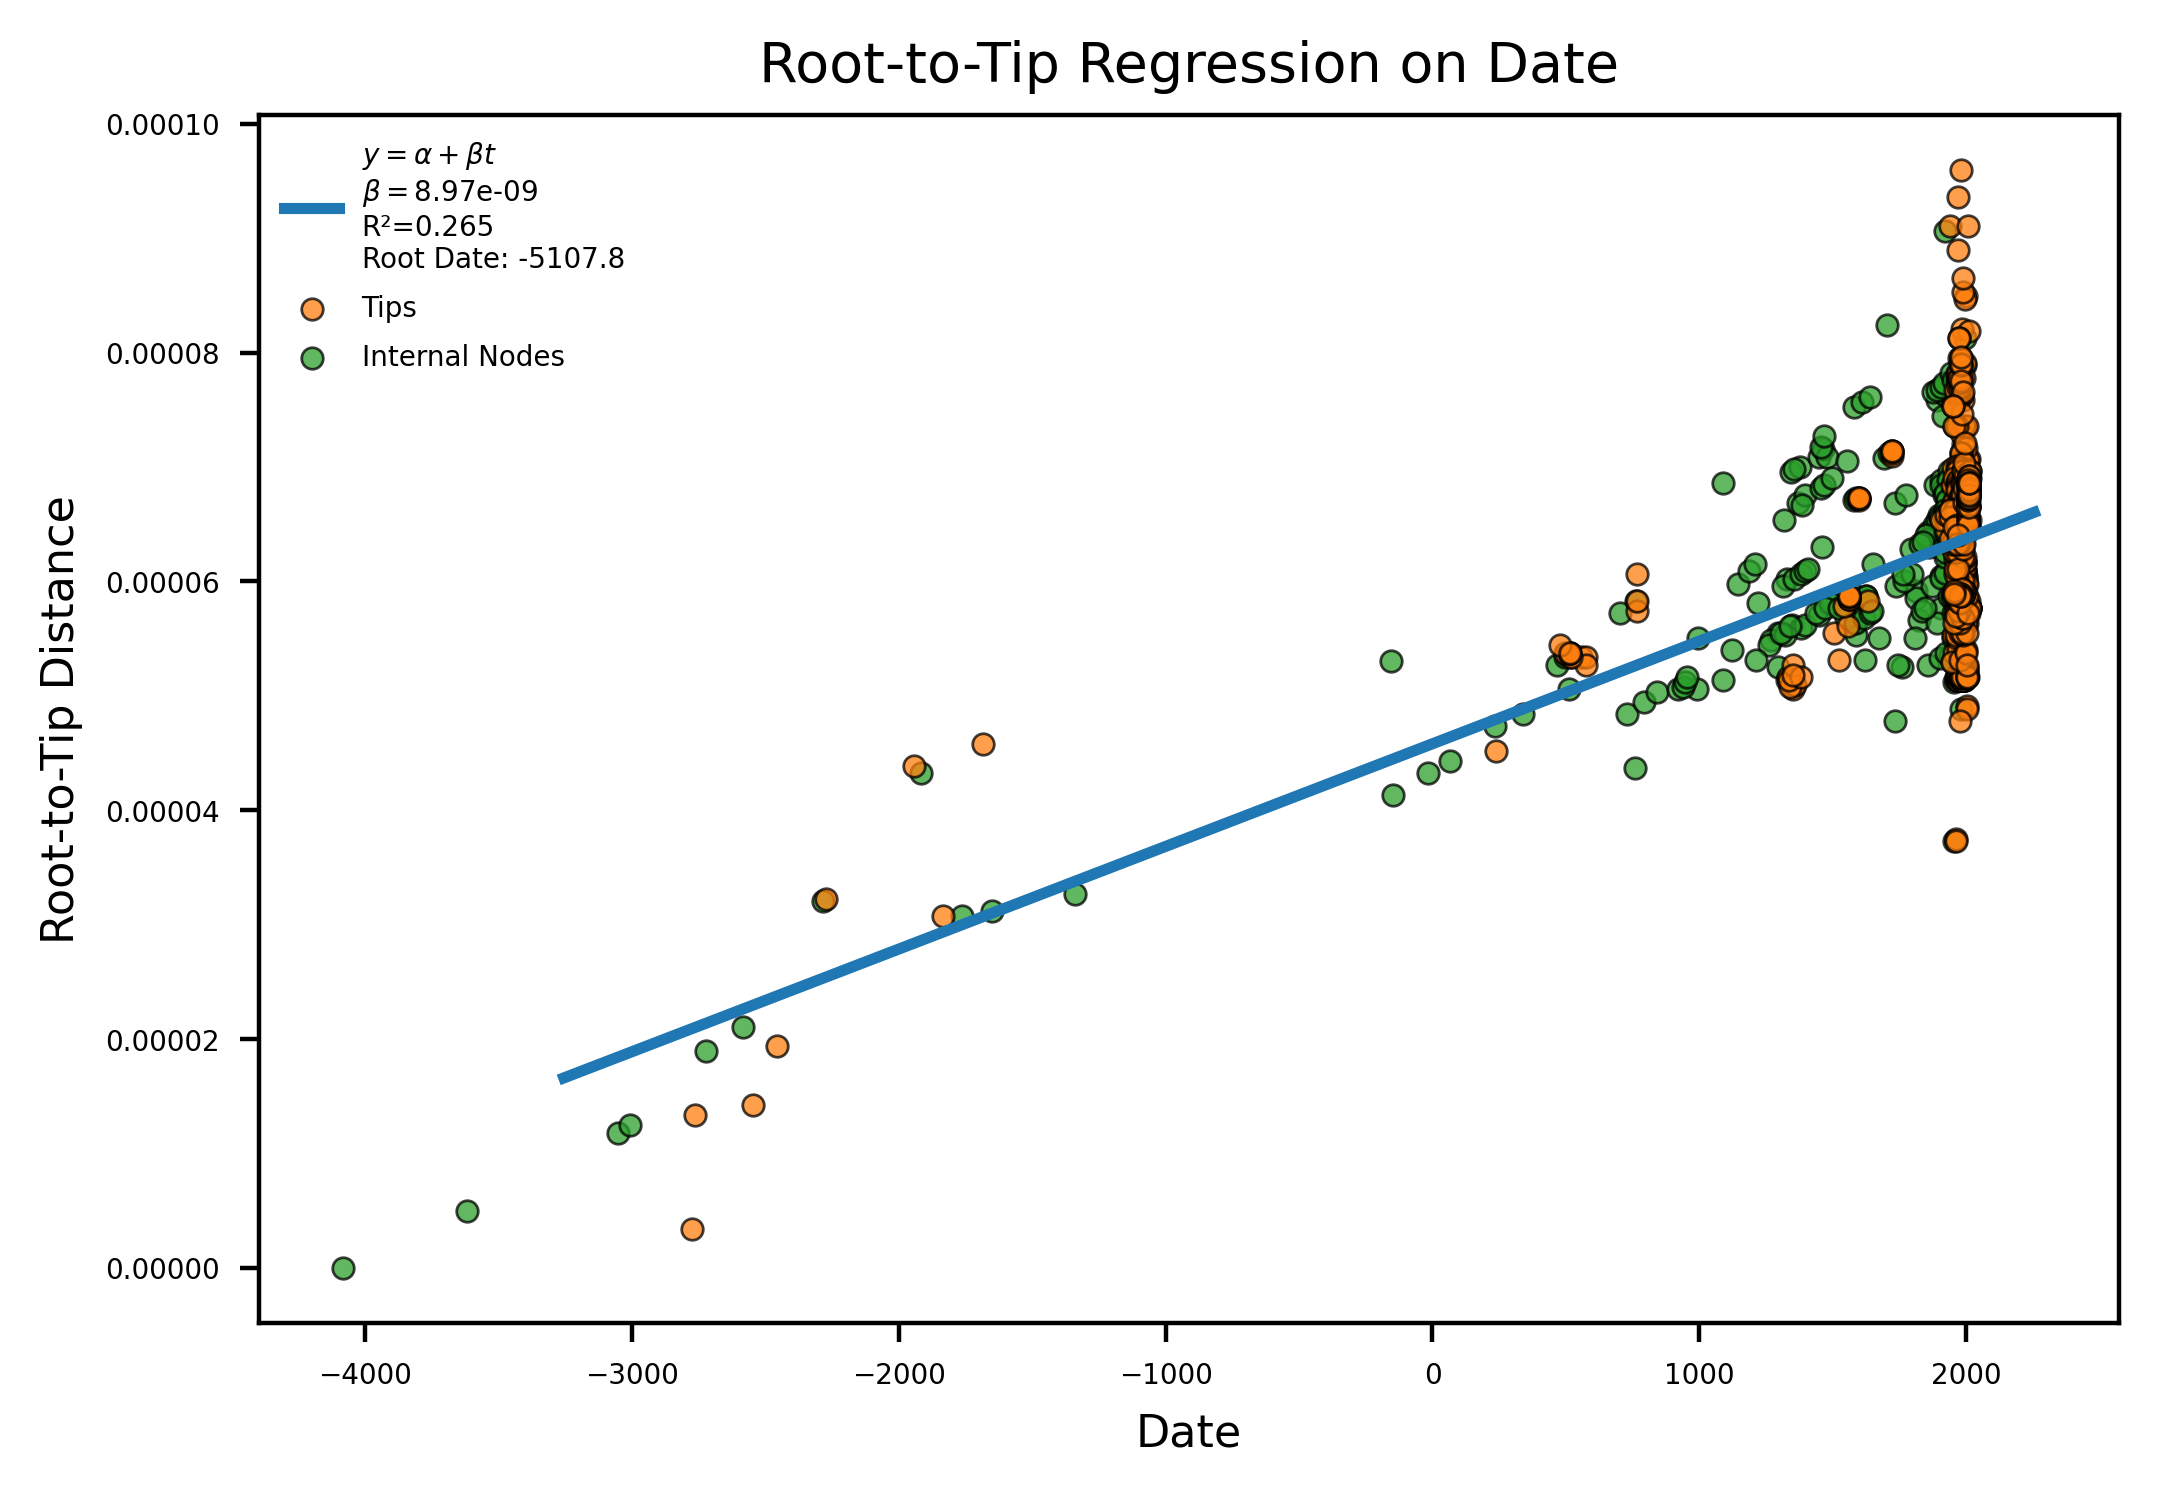

In [19]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)

tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] == TERM_COL)]
int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]
regression = tt.clock_model
t_mrca = -regression['intercept']/regression['slope']
# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

### Important events to label

In [20]:
tt_copy = copy.deepcopy(tt)
black_death_node = tt_copy.tree.common_ancestor("SAMN00715800") # black death node: 8291
justinian_plague_node = tt_copy.tree.common_ancestor("SAMEA4354665") #justinian plague node: AE1175 
first_pandemic_mrca =  tt_copy.tree.common_ancestor("SAMEA4354665", "SAMEA1061800") # AE1175, DA101
second_pandemic_mrca = tt_copy.tree.common_ancestor("SAMN00715800","SAMEA3713715", "SAMEA5818822") # 8291, OBS137, STN008
third_pandemic_tips = list(tree_df[(tree_df["Branch_Major"] == "1.ORI")].index)
third_pandemic_mrca = tt_copy.tree.common_ancestor(third_pandemic_tips)

target_attr = {"2.ANT": '', "2.MED": '', "3.ANT": "", "4.ANT": ""}
for c in tt_copy.tree.get_terminals():
    mug_val = tree_df[MUG_ATTR][c.name]
    if mug_val in target_attr and not target_attr[mug_val]:
        target_attr[mug_val] = c
        
big_bang_node = tt_copy.tree.common_ancestor(list(target_attr.values()))

### Plot Trees

4465.07	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


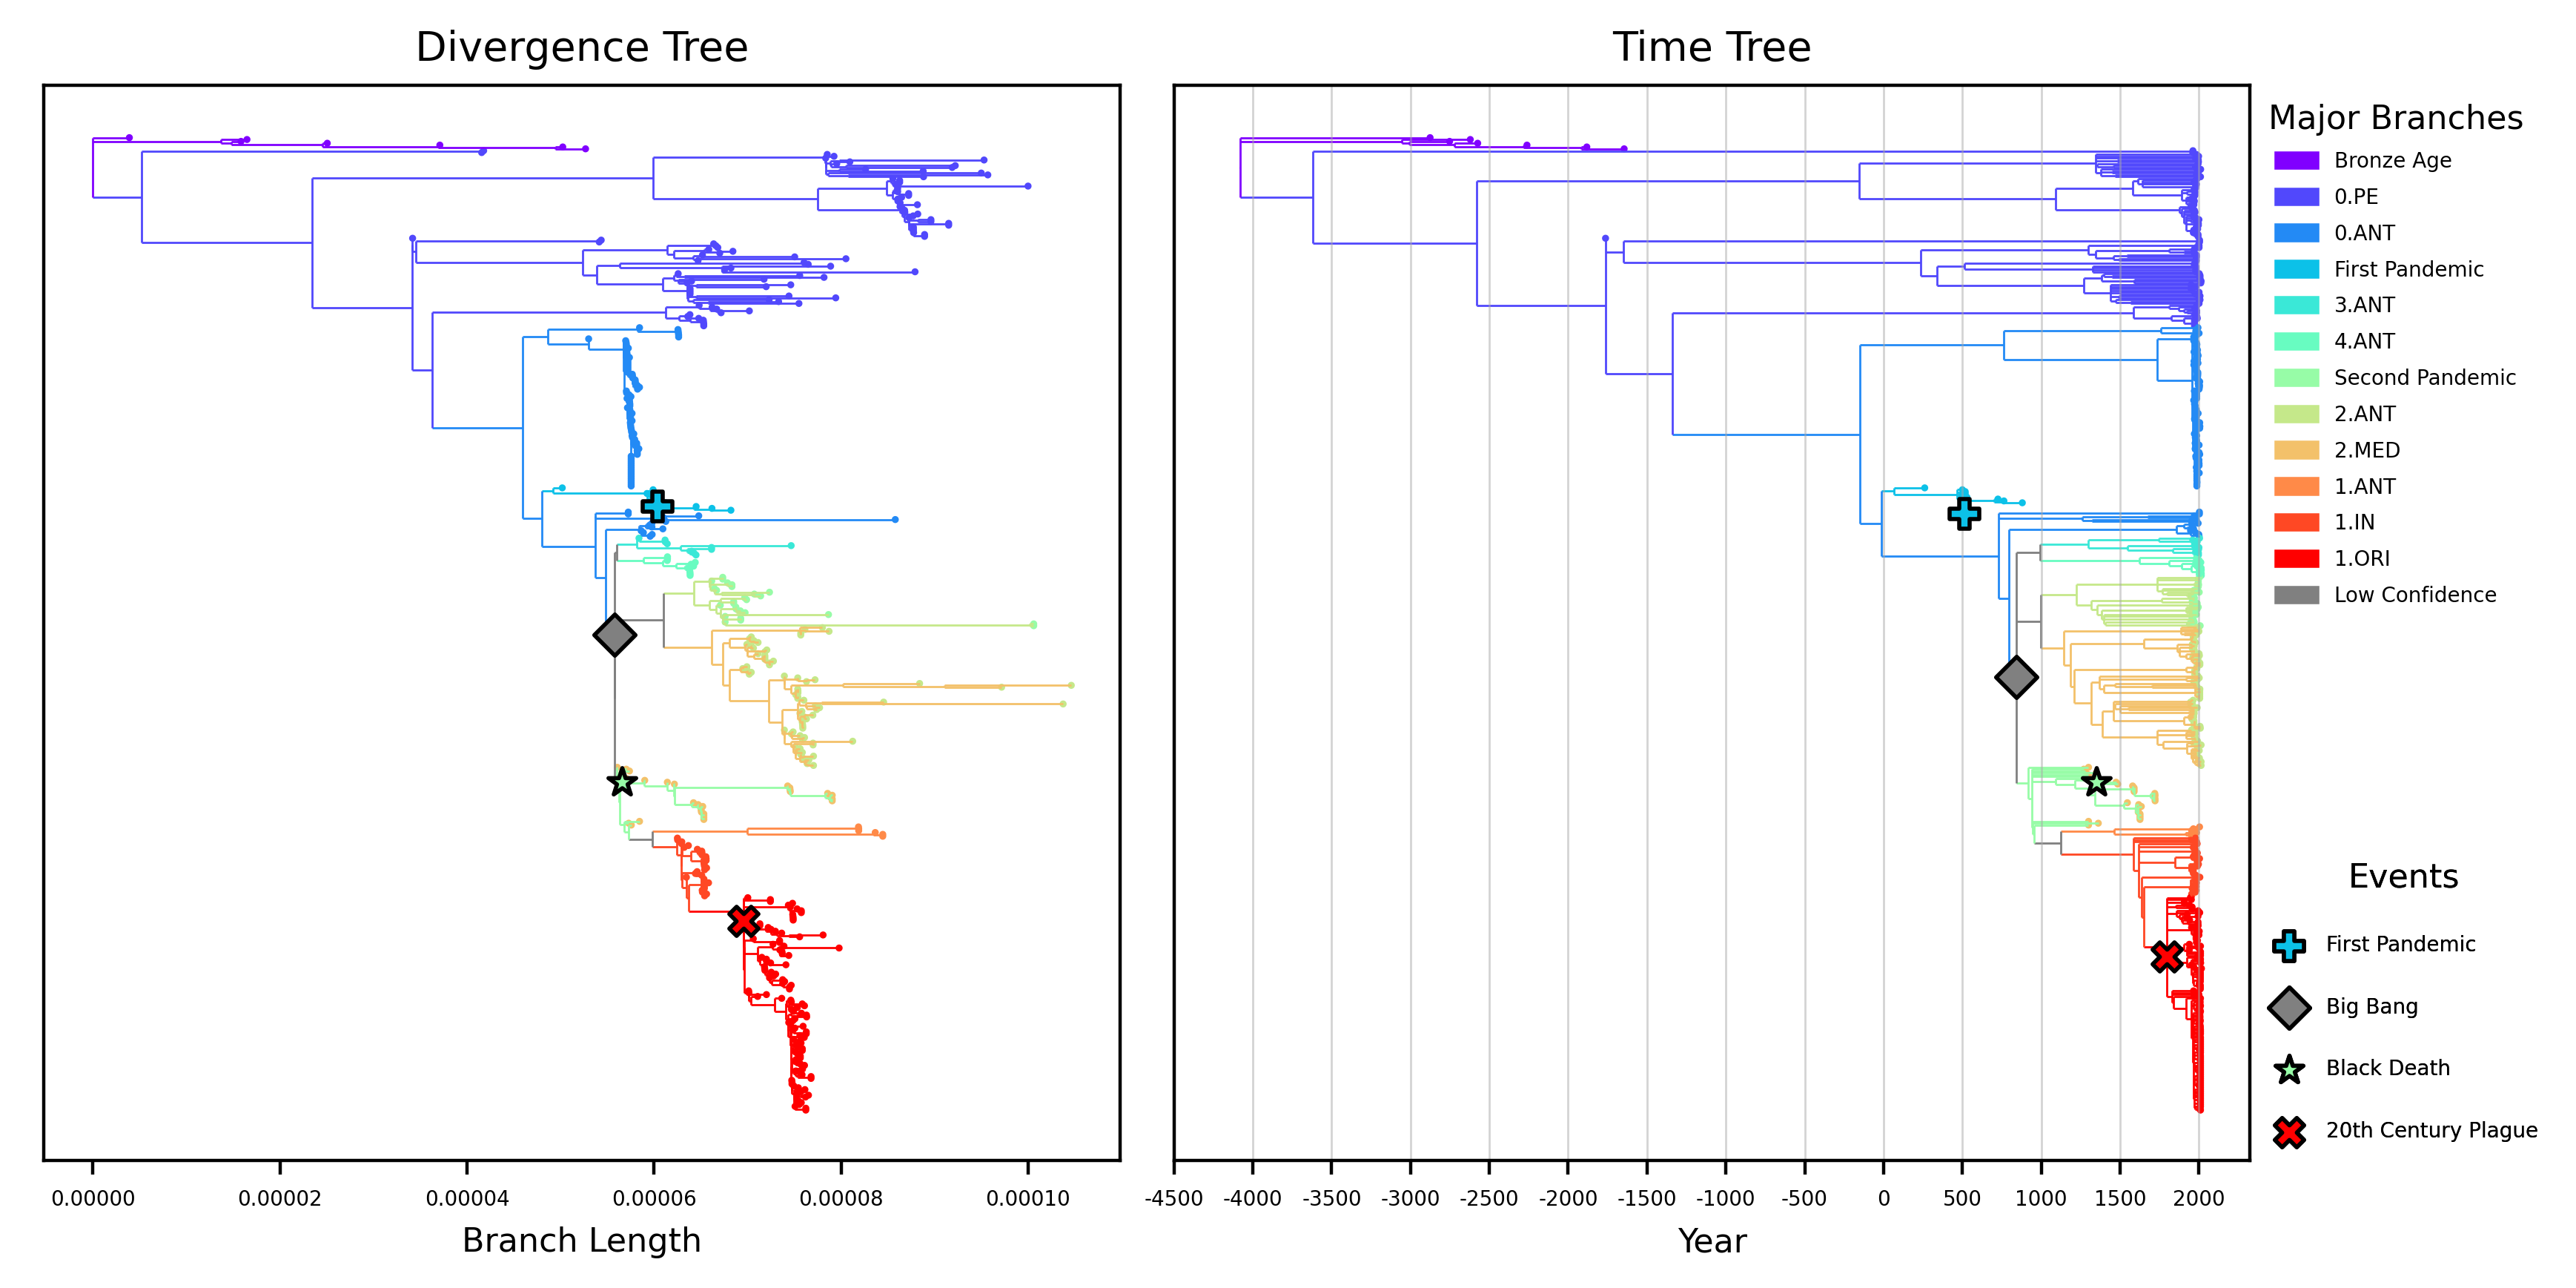

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                         dpi=dpi, 
                         gridspec_kw={'wspace': 0.05}, 
                         figsize=figsize_alt,
                         sharey=True,
                         )

plt.rc('lines', linewidth=0.5)

# Create a dictionary to hold mapping of attribute : color
# Will need this later for legend construction?
mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Make copies for modification
tree_div_copy = copy.deepcopy(tree_div)
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tree_div_copy.find_clades():
    c.color = "black"
# --------------------------------------------
# Draw trees
for t,ax in zip([tree_div_copy, tt_copy.tree], [ax1, ax2]):
    # Color the tree by an attribute
    hex_dict = color_tree(tree=t, 
                          df=tree_df, 
                          attribute="Mugration_" + MUG_ATTR,
                          attribute_confidence="Mugration_" + MUG_ATTR + "_Confidence",
                          threshold_confidence=MUG_CONF_THRESH,                          
                          color_pal=CONT_COLOR_PAL)
    # Add the Low confidence Element
    hex_dict["Low Confidence"] = "grey"
    mug_dict[MUG_ATTR]["hex_color"] = hex_dict
    Phylo.draw(t, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Draw tips
tip_div_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
tip_time_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL) & (tree_df["timetree_coord_x"] != NO_DATA_CHAR)]
for df,ax,prefix in zip([tip_div_data, tip_time_data], [ax1, ax2], ["coord_", "timetree_coord_"]):
    ax.scatter(data=df,
               x=prefix + "x", 
               y=prefix + "y",
               s=0.5, 
               c="Mugration_" + MUG_ATTR + "_Color",
               label="",)

# --------------------------------------------
# Draw events
event_marker_size = 50
event_dict = {
    "First Pandemic": {
        "node": justinian_plague_node,
        "marker": "P",
        "color": mug_dict[MUG_ATTR]["hex_color"]["First Pandemic"],
    }, 
    "Big Bang": {
        "node": big_bang_node,
        "marker": "D",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"],
    },
    "Black Death" : {
        "node": black_death_node,
        "marker": "*",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Second Pandemic"],
    },
    "20th Century Plague": {
        "node" : third_pandemic_mrca,
        "marker" : "X",
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
    }}

for event in event_dict:
    # shift markers up
    y_shift = 5
    # plot on both axes
    ax1.scatter(
        x = tree_df["coord_x"][event_dict[event]["node"].name], 
        y = tree_df["coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )    
    ax2.scatter(
        x = tree_df["timetree_coord_x"][event_dict[event]["node"].name], 
        y = tree_df["timetree_coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )

# --------------------------------------------
# Labels

ax1.set_xlabel('Branch Length')
ax1.set_ylabel('')    

ax2.set_xlabel('Year')
ax2.set_ylabel('')

ax1.set_title("Divergence Tree")
ax2.set_title("Time Tree")

# --------------------------------------------
# Ticks

# The y axis is not particularly meaning, remove the ticks
ax1.set_yticks([])
ax2.set_yticks([])

ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)

# Set the new tick locations and labels
ax2.set_xticks(ticks_dict["tick_locs"])
ax2.set_xticklabels(ticks_dict["tick_labels"])

# --------------------------------------------
# Lines

# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax2.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree_div_copy.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax1.set_ylim(len(tree_div_copy.get_terminals()) + y_buffer, 0 - y_buffer)

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

# No x buffer on lower end
ax2.set_xlim(ticks_dict["tick_locs"][0], ticks_dict["tick_locs"][-1] + x_buffer)
ax2.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Legends

# Make a custom patches legend for the mugration attribute
legend_mug_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[MUG_ATTR]["hex_color"].values()]
legend_mug_labels = list(mug_dict[MUG_ATTR]["hex_color"].keys())

legend_mug = ax2.legend(legend_mug_elements, 
           legend_mug_labels, 
           bbox_to_anchor=(1.0, 1.0), 
           loc='upper left', 
           title="Major Branches",)

legend_events = ax2.legend(bbox_to_anchor=(1.0, 0.00), 
           loc='lower left',
           title="Events",
           labelspacing=2,)

# Add multiple legends as artists
ax2.add_artist(legend_mug)
ax2.add_artist(legend_events)

# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree_{}.".format(MUG_ATTR.lower(), FMT))  
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

### Date Conversion

## Black Death / Second Pandemic

I want this to be a subtree that starts at the common ancestor of all the "Second Pandemic" strains. I also want to be able to collapse/prune(?) the clades that come after the Second Pandemic: 1.ANT, 1.IN, 1.ORI

CURRENTLY BROKEN!

/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator


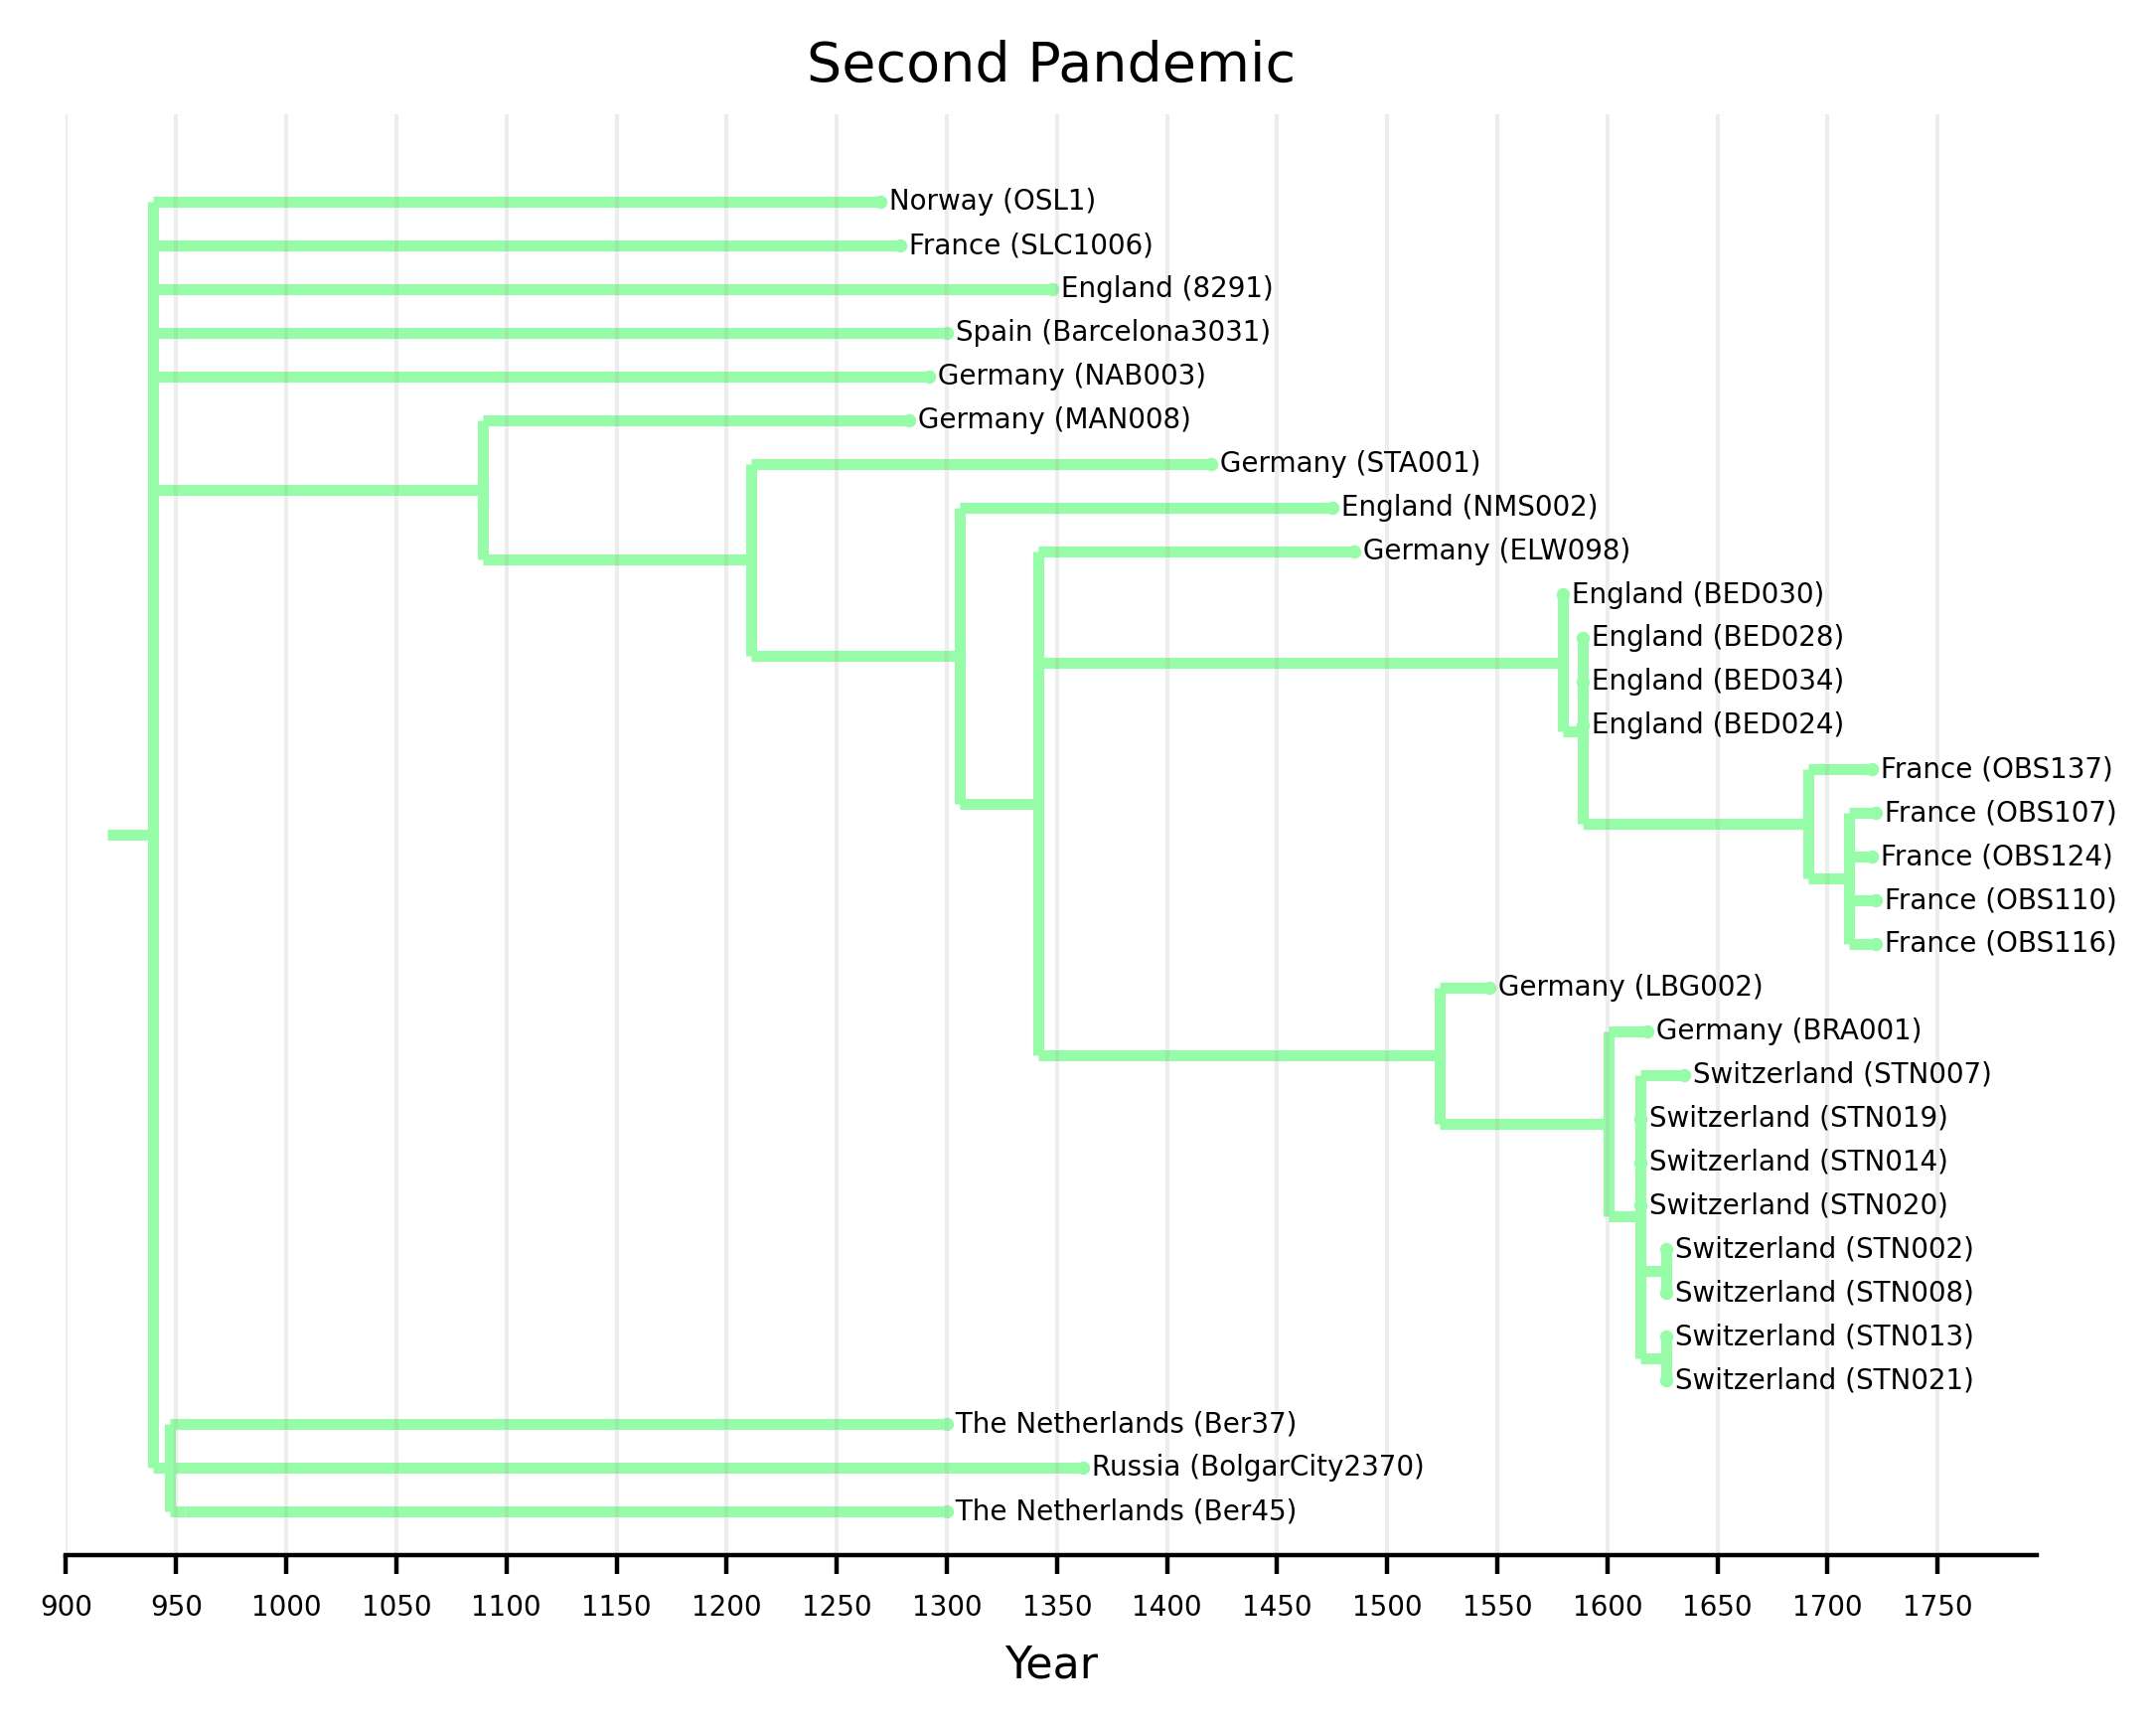

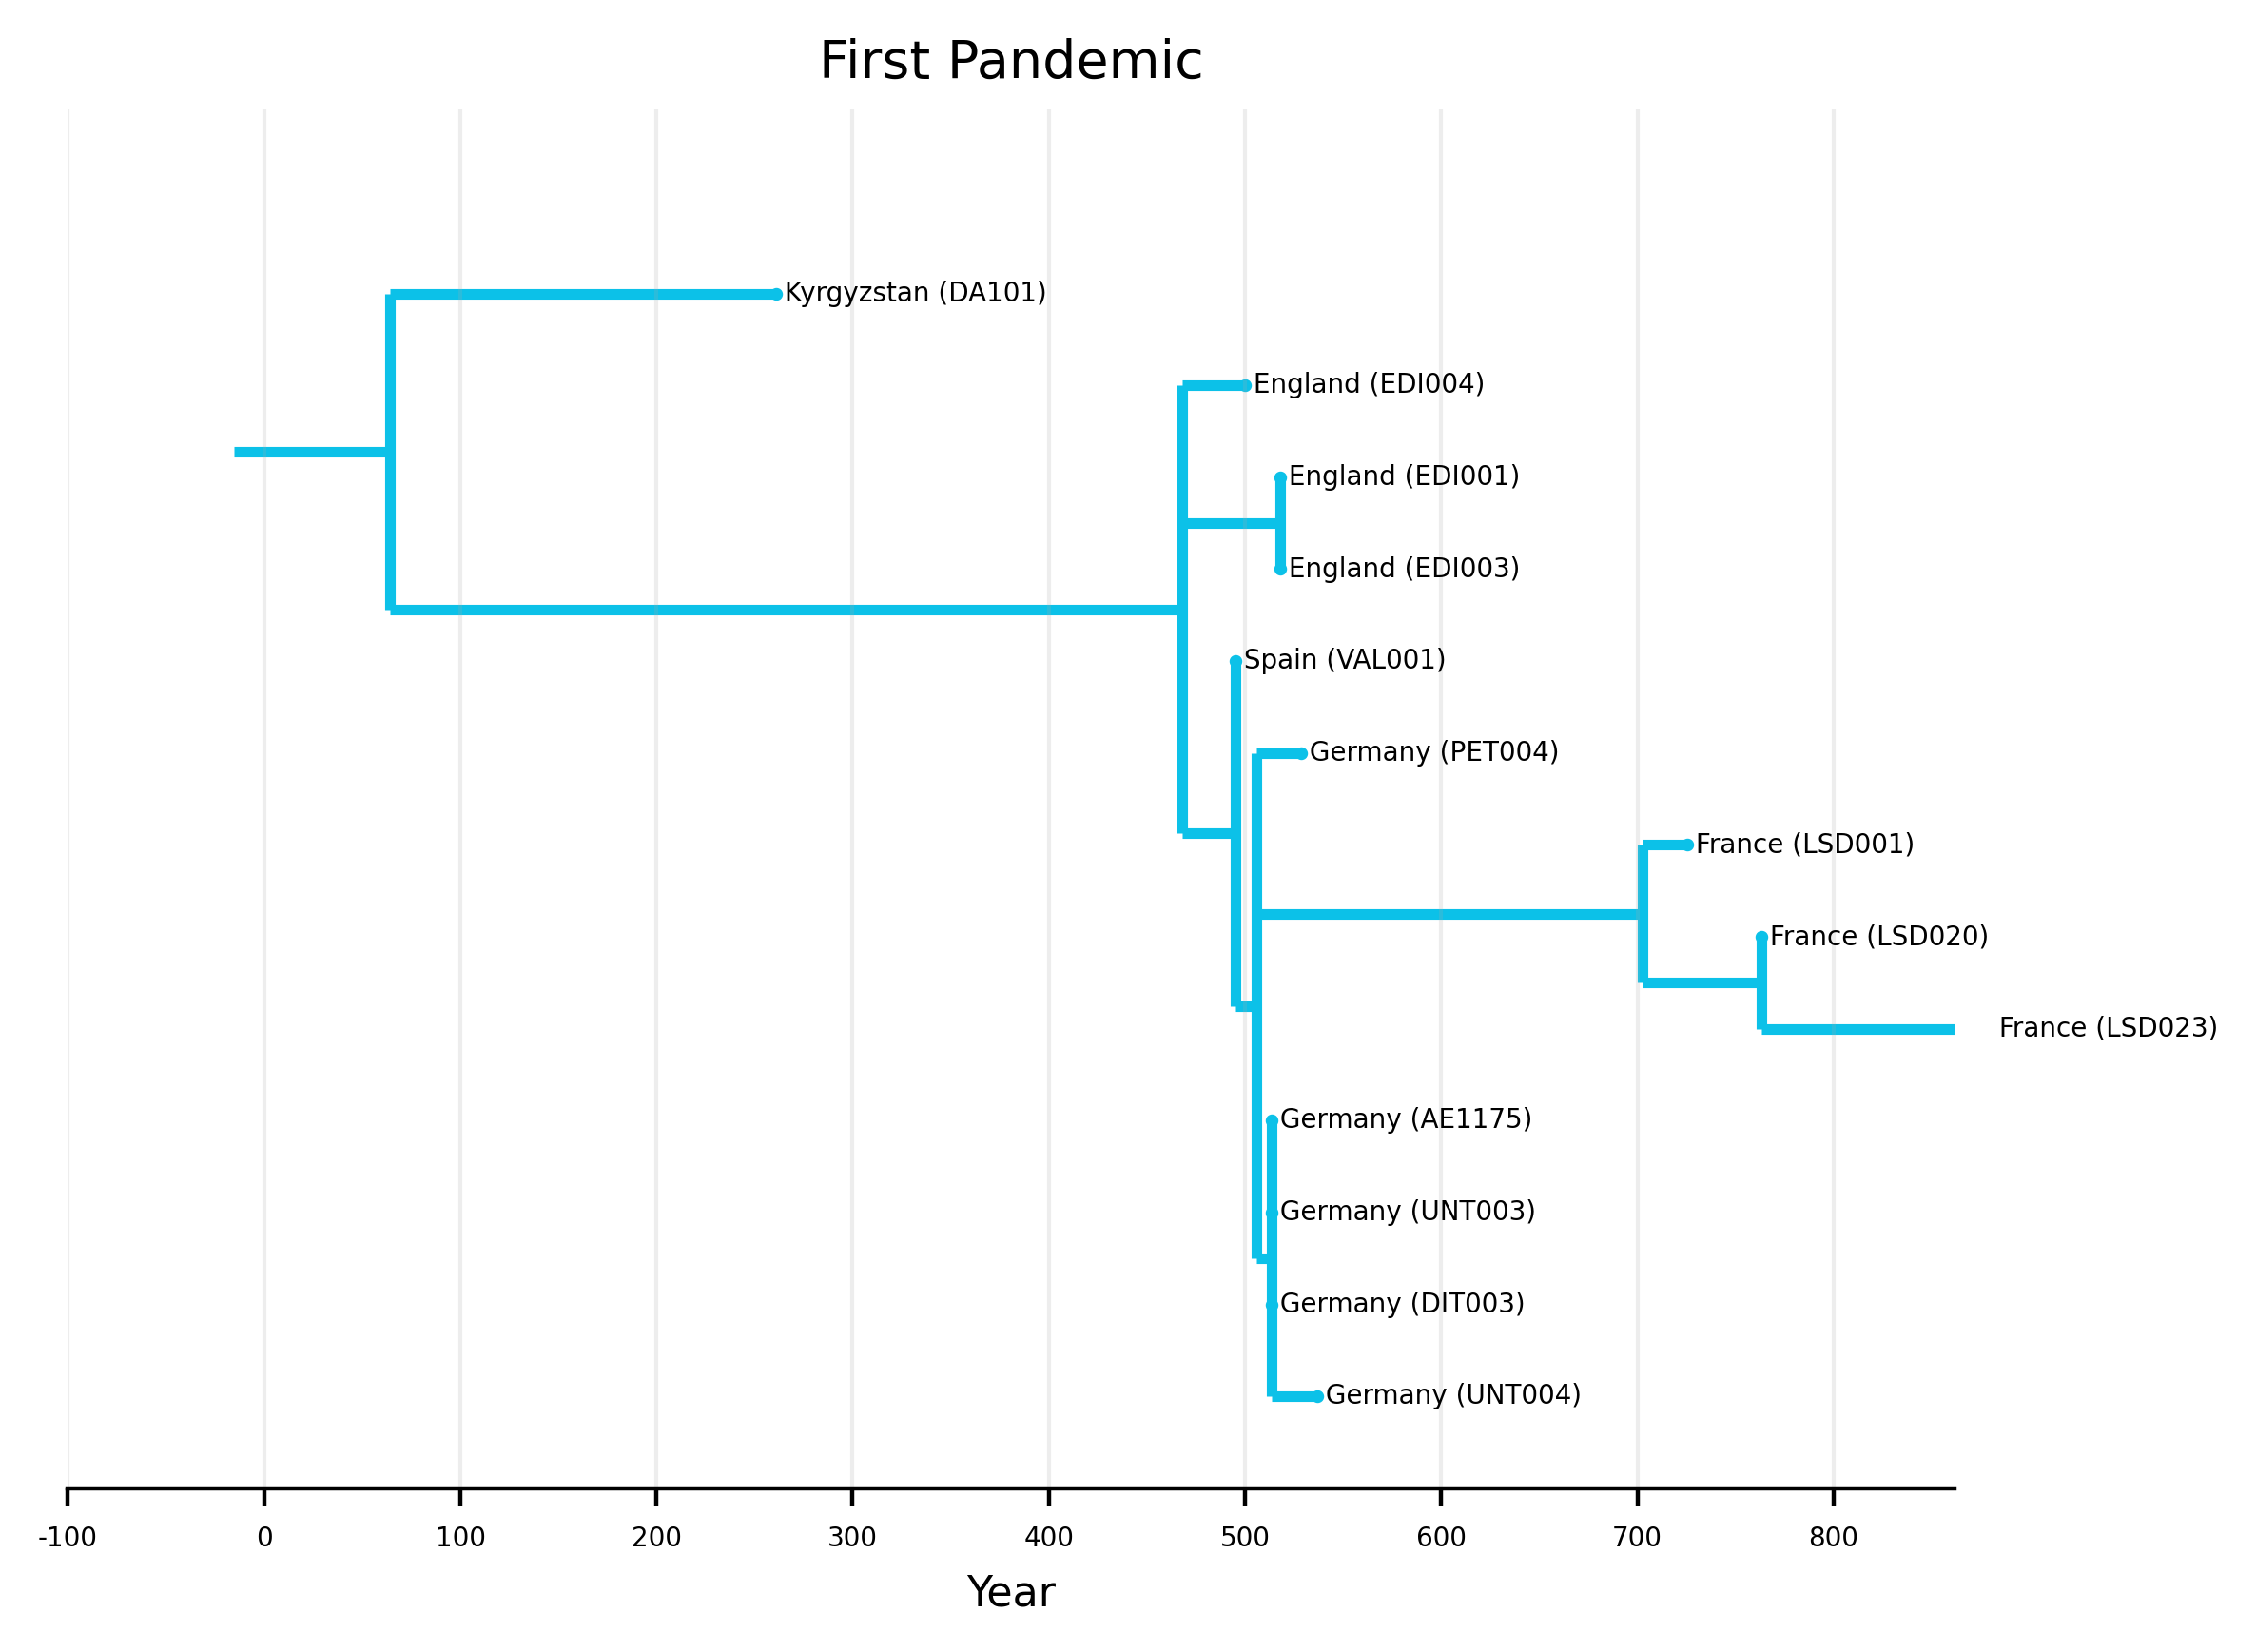

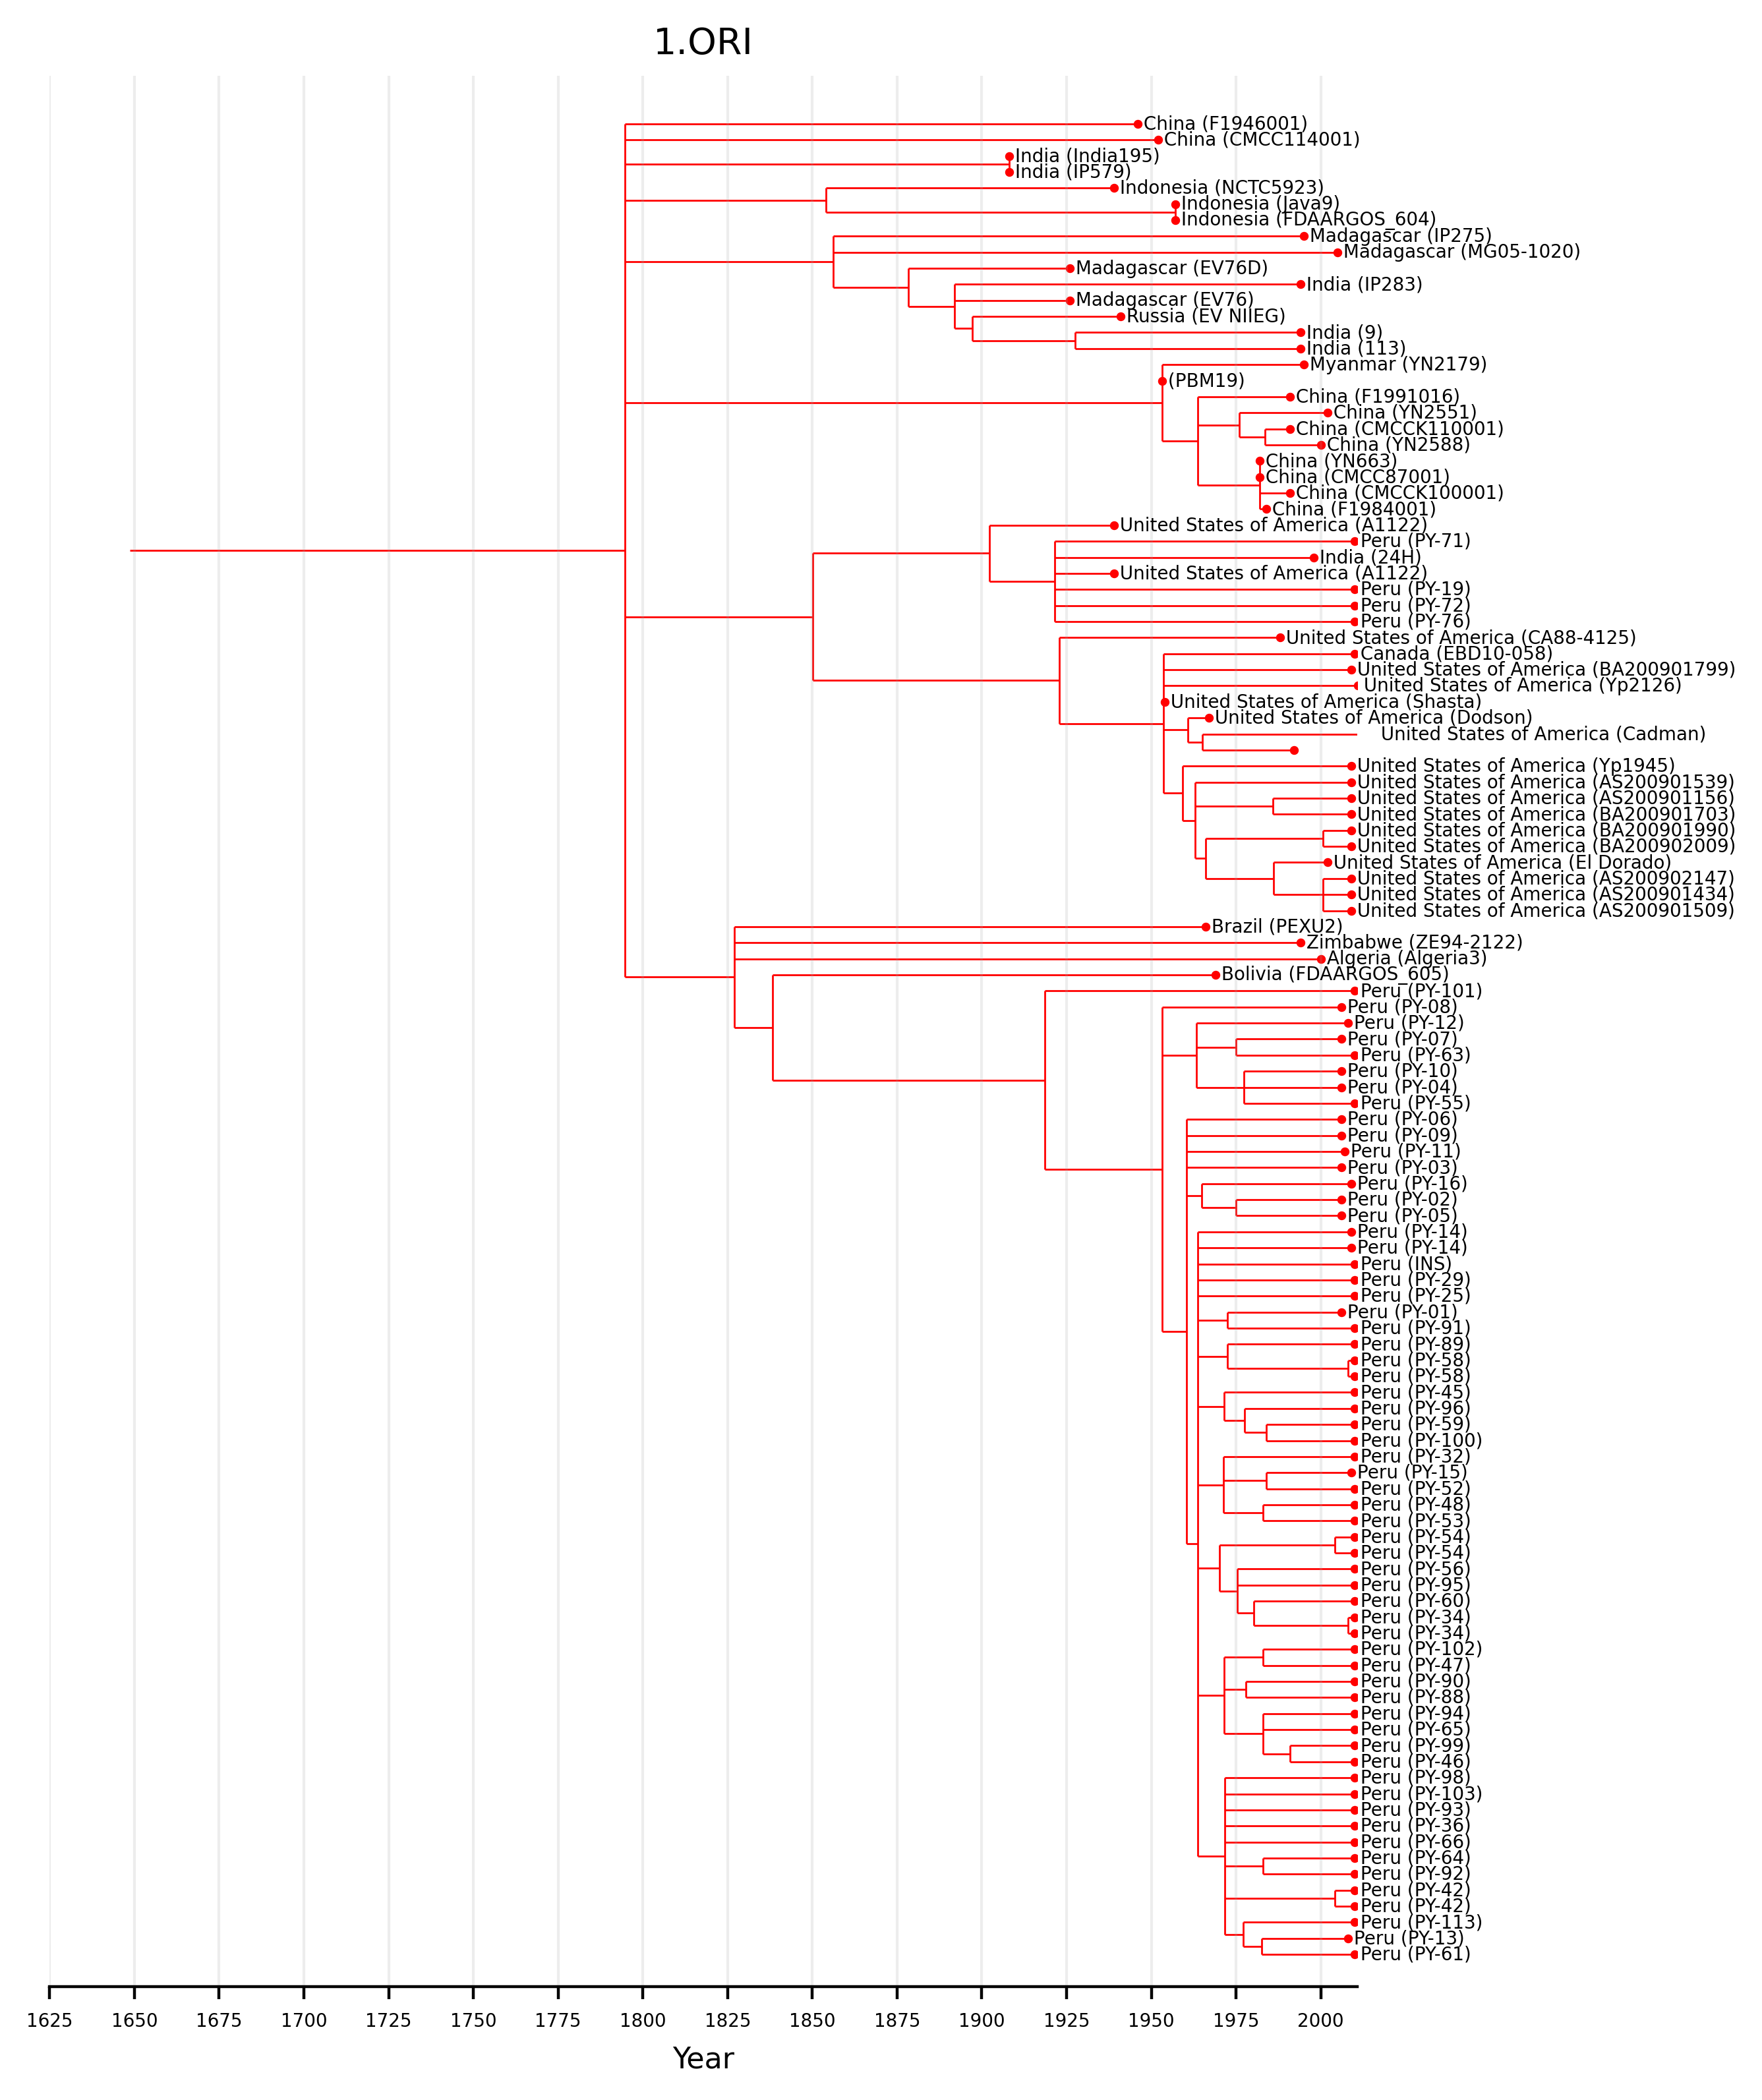

In [190]:
subtree_dict = {
    "Second Pandemic" : {
        "tips": ["SAMN00715800","SAMEA3713715", "SAMEA5818822"], # 8291, OBS137, STN008
        "color": mug_dict[MUG_ATTR]["hex_color"]["Second Pandemic"],
        "node" : second_pandemic_mrca,
        "collapse": {"1.ORI": '', "1.IN": '', "1.ANT": ''},
        "step" : 50,
    },
    "First Pandemic" : {
        "tips": ["SAMEA4354665", "SAMEA1061800"], # AE1175, DA101
        "color": mug_dict[MUG_ATTR]["hex_color"]["First Pandemic"],
        "node" : first_pandemic_mrca,
        "collapse": {},
        "step" : 100,
    },  
    "1.ORI" : {
        "tips": ["Reference"],
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
        "node" : third_pandemic_mrca,
        "collapse": {},
        "step" : 25,
    },      
}

# No copying is preferred here, we use the trees modified from the previous plotting step
# Select nodes will be copied so the original tree is not collapsed

for event_label in subtree_dict:
    # If a node was not provided, search for the mrca of the provided tips
    if not subtree_dict[event_label]["node"]:
        subtree_dict[event_label]["node"] = tt_copy.tree.common_ancestor(subtree_dict[event_label]["tips"])
    
    t = tt_copy.tree.common_ancestor(subtree_dict[event_label]["node"].name)
    # make a copy so we don't modify the original node directly
    t = copy.deepcopy(t)
           
    # --------------------------------------------
    # Collapse Undesired Clades
    if len(subtree_dict[event_label]["collapse"].values()) > 0:   
        # Find the first tip that full fills the value criteria
        for c in t.get_terminals():
            mug_val = tree_df[MUG_ATTR][c.name]
            if mug_val in subtree_dict[event_label]["collapse"] and not subtree_dict[event_label]["collapse"][mug_val]:
                subtree_dict[event_label]["collapse"][mug_val] = c.name
        
        target_nodes =  list(subtree_dict[event_label]["collapse"].values())
        if len("".join(target_nodes)) > 0:
            collapse_node = t.common_ancestor(target_nodes)       
            # Collapse all clades
            for c in collapse_node.find_clades():
                t.collapse(target=c.name)
        
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)
    
    # --------------------------------------------
    # Draw Tree
    # Scale line width depending on samples
    if len(t.get_terminals()) < 50:
        plt.rc('lines', linewidth=2)
    else:
        plt.rc('lines', linewidth=0.5)
        fig.set_size_inches(figsize[0], figsize[1] * 2)
    #label_func = lambda x: tree_df["Strain"][x.name] if tree_df["Strain"][x.name] != "NA" else ""
    label_func = lambda x: (
        "{} ({})".format(tree_df["Country"][x.name], tree_df["Strain"][x.name]) 
                  if tree_df["Country"][x.name] != "NA" 
                  else "({})".format(tree_df["Strain"][x.name])
                    if tree_df["Strain"][x.name] != "NA"
                  else ""
    )
    Phylo.draw(t,
               axes=ax1, 
               show_confidence=False, 
               label_func = label_func, 
               do_show=False)

    # --------------------------------------------
    # Labels
    ax1.set_xlabel("Year")
    ax1.set_ylabel("")  
    ax1.set_title(event_label)
    
    # --------------------------------------------
    # Ticks

    # The y axis is not particularly meaning, remove the ticks
    ax1.set_yticks([])

    ticks_dict = convert_timetree_ticks(tree=t, step=subtree_dict[event_label]["step"])
    ax1.set_xticklabels(ticks_dict["tick_labels"])
    ax1.set_xticks(ticks_dict["tick_locs"])

    date_to_x = float(ticks_dict["tick_labels"][-1]) - float(ticks_dict["tick_locs"][-1])

    # --------------------------------------------
    # Draw Tips

    tip_x = [c.numdate - date_to_x for c in t.get_terminals()]
    tip_y = [i for i in range(1,len(t.get_terminals())+ 1)]
    ax1.scatter(x=tip_x, 
                y=tip_y, 
                s=2, 
                c=mug_dict[MUG_ATTR]["hex_color"][event_label],
                label="",)

    # --------------------------------------------
    # Lines

    # Vertical lines for dates
    for loc in ticks_dict["tick_locs"]:
        ax1.axvline(x=loc, color="darkgrey", alpha=0.2, linewidth=0.75)

        
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(False)
    # --------------------------------------------
    # Limits
    date_range = np.max([n.numdate for n in t.get_terminals()]) - np.min([n.numdate for n in t.get_terminals()])
    x_buffer = date_range * 0.1
    y_buffer = math.ceil(len(t.get_terminals()) * 0.01)
    # No left side x_buffer
    ax1.set_xlim(ticks_dict["tick_locs"][0], 
                 ticks_dict["tick_locs"][-1] + x_buffer)
    ax1.set_ylim(len(t.get_terminals()) + y_buffer, 0 - y_buffer,)

    out_path = os.path.join(outdir, SCRIPT_NAME + "_{}.{}".format(event_label.lower().replace(" ","_"), FMT))
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

### Skyline plot

	Skyline assuming 50 gen/year and approximate confidence bounds (+/- 2.000000 standard deviations of the LH)
	date 	N_e 	lower 	upper
	-4099.1	54948.0	21617.7	139667.1
	-3777.3	73439.3	36905.9	146137.5
	-3455.4	84625.6	41915.4	170856.1
	-3133.6	92668.6	47488.8	180831.6
	-2811.7	100853.8	52340.1	194334.7
	-2489.9	103940.7	52869.2	204347.3
	-2168.0	108865.8	54957.9	215651.3
	-1846.2	115549.3	59578.9	224100.2
	-1524.3	158918.1	81090.7	311440.8
	-1202.5	212256.4	106308.2	423794.0
	-880.6	224023.8	110459.1	454346.1
	-558.8	235308.1	115802.4	478141.1
	-236.9	237632.0	127532.5	442781.2
	84.9	212406.6	112966.2	399380.9
	406.8	163381.3	90236.4	295816.8
	728.6	183921.3	106554.7	317461.8
	1050.5	364005.3	235907.3	561660.6
	1372.3	387311.1	266057.1	563825.8
	1694.2	1461916.4	1241603.0	1721322.8
	2016.0	338408.1	269647.8	424702.3

 --- written skyline to ../../docs/results/latest/timetree/timetree_skyline.tsv



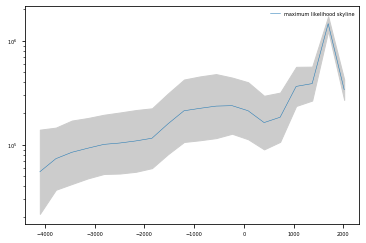

In [191]:
#treetime.wrappers.print_save_plot_skyline(tt, n_std=2.0, screen=True, save=False, plot=True)
out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )

treetime.wrappers.print_save_plot_skyline(tt, 
                                          plot=out_path_skyline_pdf, 
                                          save=out_path_skyline_txt, 
                                          screen=True)

---
## Export

In [192]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1